# MultiForest optimization notebook

## GERMANY - national policy scenario optimization

Above the code cells, there are short instructions how the users can modify the codes in the cells.<br>
If there are no instructions, no changes should be needed for the cell by default.

A detailed description is provided in the <b>README.md</b>.

## Basic definitions
Simulated forest data - name and climate scenario

In [1]:
RCP = "RCP0" # no climate change

Specify policy scenario:

- "FS" -  National Forest Strategy
- "BDS" - Biodiversity Strategy
- "BES" - Bioeconomy Strategy

In [2]:
scenario ="BES"

## Read the data

In [3]:
import wget
import os
import numpy as np
import pandas as pd
import sys

In [4]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/py_class")

import multiFunctionalOptimization as MFO

In [5]:
from importlib import reload
reload(MFO)

<module 'multiFunctionalOptimization' from '/home/ubuntu/workspace/mf_optimization_demo/py_class/multiFunctionalOptimization.py'>

In [7]:
mfo = MFO.MultiFunctionalOptimization()

'Using CLP'

In [8]:
filename = "rslt_"+RCP+"_Bavaria_Germany_pause_2_V1.zip" # test data for Bavaria with no CC
filename

'rslt_RCP0_Bavaria_Germany_pause_2_V1.zip'

In [9]:
filename

'rslt_RCP0_Bavaria_Germany_pause_2_V1.zip'

In [10]:
if not filename in os.listdir("."):
    wget.download("https://syncandshare.lrz.de/download/MktBZ3hBbzR2UnhwcWk4YXYxcVFj/Data/"+filename)

In [44]:
%%time
mfo.readData(filename,
             sampleRatio=0.2 #If no sample ratio given, the ratio is assumed to be 1
                             #0.2 means 20% of the data
            ) 

'sample size 745/3725(20%)'

CPU times: user 3 s, sys: 1.17 s, total: 4.17 s
Wall time: 4.17 s


In [45]:
mfo.data.columns

Index(['id', 'regime', 'year', 'ecoregion', 'V_strat', 'V_strat_reg',
       'Ve_strat', 'Vm_strat', 'iV_strat', 'pct_coni', 'pct_reg_coni',
       'pct_deci', 'pct_reg_deci', 'spruce_pct', 'spruce_reg_pct', 'fir_pct',
       'fir_reg_pct', 'pine_pct', 'pine_reg_pct', 'larch_pct', 'larch_reg_pct',
       'beech_pct', 'beech_reg_pct', 'oak_pct', 'oak_reg_pct',
       'douglasfir_pct', 'douglasfir_reg_pct', 'hardbrl_pct',
       'hardbrl_reg_pct', 'softbrl_pct', 'softbrl_reg_pct', 'spi', 'spi_reg',
       'maxh', 'maxh_reg', 'spint', 'freq_h_0_50', 'freq_h_50_80',
       'freq_h_80_100', 'cntlayers', 'shan_species', 'shan_species_reg',
       'shan_height', 'volHa_dbhGR10', 'volHa_dbhGR20', 'volHa_dbhGR30',
       'volHa_dbhGR40', 'volHa_dbhGR50', 'volHa_dbhGR60', 'volHa_dead_dbhGR30',
       'volHa_dead_dbhGR40', 'volHa_dead_dbhGR50', 'volHa_dead_dbhGR60',
       'sawntimber', 'industrywood', 'yieldloss', 'remaininstand',
       'represented_area_by_NFIplot', 'region', 'NUTS2', 'clear_c

## Create new columns

In [46]:
mfo.data["HarvestedVolume"] = (mfo.data["Ve_strat"].values)*mfo.data["represented_area_by_NFIplot"].values

In [47]:
mfo.data["CarbonBalance"] = (mfo.data["BalanceCarbonTotalYear"].values)*mfo.data["represented_area_by_NFIplot"].values

In [48]:
mfo.data["AnnualIncrement"] = mfo.data["iV_strat"].values*mfo.data["represented_area_by_NFIplot"].values

In [49]:
mfo.data["speciesProfileIndex"] = mfo.data["spi"].values 

In [50]:
mfo.data["VolumeLargeTrees"] = mfo.data["volHa_dbhGR60"].values*mfo.data["represented_area_by_NFIplot"].values

In [51]:
mfo.data["speciesInterminglingIndex"] = mfo.data["spint"].values

In [52]:
mfo.data["ShannonIndexSpecies"] = mfo.data["shan_species"].values

In [53]:
mfo.data["ShannonIndexTreeHeight"] = mfo.data["shan_height"].values

In [54]:
mfo.data["standingVolume"] = mfo.data["V_strat"]*mfo.data["represented_area_by_NFIplot"].values

In [55]:
mfo.data["noNaturalSpecies"] = mfo.data.apply(lambda x: sum([x[name] for name in mfo.data.columns if "pnv" in name]),axis=1)

In [56]:
mfo.data["stateForest"] = mfo.data['landtenure'].apply(lambda x: 1 if x < 1000 else 0)

In [57]:
mfo.data["SawTimber"] = mfo.data["V Sawlogs"].values*mfo.data["represented_area_by_NFIplot"].values

In [58]:
mfo.data["PulpWood"] =mfo.data["V PulpWood"].values*mfo.data["represented_area_by_NFIplot"].values

In [59]:
mfo.data["ForestResidues"] =mfo.data["V HarvestResidues"].values*mfo.data["represented_area_by_NFIplot"].values

In [60]:
mfo.data["Fuelwood"] = mfo.data["fuelwood"].values*mfo.data["represented_area_by_NFIplot"].values

In [61]:
mfo.data["energyProds"] =mfo.data["CFsawlogsToEnergy"].values*mfo.data["represented_area_by_NFIplot"].values

In [62]:
mfo.data["TotalLivingCarbon"] = (mfo.data["CSagbLivingTotal"].values + mfo.data["CSbgbLivingTotal"].values )*mfo.data["represented_area_by_NFIplot"].values

In [63]:
mfo.data["pnvDeviation"] =((mfo.data["pnv_spruce"].values*100/mfo.data["noNaturalSpecies"].values - mfo.data["spruce_pct"].values)**2 + 
                      (mfo.data["pnv_beech"].values*100/mfo.data["noNaturalSpecies"].values - mfo.data["beech_pct"].values)**2 +
                      (mfo.data["pnv_pine"].values*100/mfo.data["noNaturalSpecies"].values - mfo.data["pine_pct"].values)**2+
                      (mfo.data["pnv_fir"].values*100/mfo.data["noNaturalSpecies"].values - mfo.data["fir_pct"].values)**2+
                      (mfo.data["pnv_oak"].values*100/mfo.data["noNaturalSpecies"].values - mfo.data["oak_pct"].values)**2)

<ipython-input-63-a5a52783099c>:1: RuntimeWarning: invalid value encountered in true_divide
  mfo.data["pnvDeviation"] =((mfo.data["pnv_spruce"].values*100/mfo.data["noNaturalSpecies"].values - mfo.data["spruce_pct"].values)**2 +
<ipython-input-63-a5a52783099c>:2: RuntimeWarning: invalid value encountered in true_divide
  (mfo.data["pnv_beech"].values*100/mfo.data["noNaturalSpecies"].values - mfo.data["beech_pct"].values)**2 +
<ipython-input-63-a5a52783099c>:3: RuntimeWarning: invalid value encountered in true_divide
  (mfo.data["pnv_pine"].values*100/mfo.data["noNaturalSpecies"].values - mfo.data["pine_pct"].values)**2+
<ipython-input-63-a5a52783099c>:4: RuntimeWarning: invalid value encountered in true_divide
  (mfo.data["pnv_fir"].values*100/mfo.data["noNaturalSpecies"].values - mfo.data["fir_pct"].values)**2+
<ipython-input-63-a5a52783099c>:5: RuntimeWarning: invalid value encountered in true_divide
  (mfo.data["pnv_oak"].values*100/mfo.data["noNaturalSpecies"].values - mfo.data["o

In [64]:
mfo.data["pnvDeviation"].replace(np.nan,0,inplace=True)

In [65]:
mfo.data["pnvDeviation"]

1506       2678.1940
1507       1518.9525
1508       1297.2125
1509       1332.3605
1510        990.3757
             ...    
1120920       0.0000
1120921       0.0000
1120922       0.0000
1120923       0.0000
1120924       0.0000
Name: pnvDeviation, Length: 224245, dtype: float64

In [66]:
mfo.data[mfo.regimesEnu].value_counts()

BAU_0            14900
CCF_P3_p1        14900
BAU_1            14900
BAU_RR_p1        14900
CCF_P1           14900
CCF_P2           14900
BAU_0_p2         14900
CCF_STATE        14900
BAU_RR_p2        14900
NOT              14900
CCF_P3_p2        14900
CCF_P3           14900
BAU_RR           14900
BAU_FS1          14900
BAU_0_p1         14900
initial_state      745
Name: regime, dtype: int64

### add column to restrict SA¶

In [67]:
regimeClassNames = {"regimeClass0name":"CCF","regimeClass1name":"SA"}
regimeClassregimes = {"regimeClass0regimes":["CCF_P3 ","CCF_P3_p1","CCF_P3_p2"],"regimeClass1regimes":["NOT"]}

In [68]:
mfo.addRegimeClassifications(regimeClassNames = regimeClassNames,regimeClassregimes=regimeClassregimes)

In [69]:
mfo.finalizeData(initialRegime="initial_state")

In [70]:
mfo.initialData.head()

,,,ecoregion,V_strat,V_strat_reg,Ve_strat,Vm_strat,iV_strat,pct_coni,pct_reg_coni,pct_deci,pct_reg_deci,...,stateForest,SawTimber,PulpWood,ForestResidues,Fuelwood,energyProds,TotalLivingCarbon,pnvDeviation,CCF_forests,SA_forests
id,year,regime,,,,,,,,,,,,,,,,,,,,,
6,2012,initial_state,9.6.2,138.631058,0.0,0.0,0.0,138.631058,36.0,0.0,64.0,0.0,...,1,0.0,0.0,0.0,0.0,0.0,53294.405274,3532.1936,False,False
10,2012,initial_state,9.15.5,228.104820,0.0,0.0,0.0,228.104820,7.0,0.0,93.0,0.0,...,1,0.0,0.0,0.0,0.0,0.0,45645.839112,2788.2760,False,False
14,2012,initial_state,9.5.2,182.529020,0.0,0.0,0.0,182.529020,5.0,0.0,95.0,0.0,...,1,0.0,0.0,0.0,0.0,0.0,36610.808570,2207.9282,False,False
18,2012,initial_state,9.5.8,395.745146,0.0,0.0,0.0,395.745146,28.0,0.0,72.0,0.0,...,1,0.0,0.0,0.0,0.0,0.0,154026.328969,5271.9176,False,False
20,2012,initial_state,9.6.3,185.863275,0.0,0.0,0.0,185.863275,0.0,0.0,100.0,0.0,...,1,0.0,0.0,0.0,0.0,0.0,37487.865513,10000.0000,False,False


In [71]:
mfo.data.head()

ecoregion     V_strat  V_strat_reg  Ve_strat   Vm_strat  \
id year regime                                                             
6  2017 BAU_0        9.6.2  202.927642     0.614593       0.0  16.772962   
        BAU_0_p1     9.6.2  202.912150     0.588503       0.0  16.612431   
        BAU_0_p2     9.6.2  186.253553     0.992174       0.0  27.230879   
        BAU_1        9.6.2  203.502270     0.634451       0.0  16.233236   
        BAU_FS1      9.6.2  201.778571     0.645147       0.0  17.888440   

                   iV_strat  pct_coni  pct_reg_coni  pct_deci  pct_reg_deci  \
id year regime                                                                
6  2017 BAU_0     81.069546      30.0          33.0      70.0          67.0   
        BAU_0_p1  80.893523      30.0          39.0      70.0          61.0   
        BAU_0_p2  74.853373      28.0          36.0      72.0          64.0   
        BAU_1     81.104448      31.0          45.0      69.0          55.0   
        BAU_FS1   81.035954      30.0          38.0      70.0          62.0   

                  ...  Relative_relative_Volume  Relative_AnnualIncrement  \
id year regime    ...                                                       
6  2017 BAU_0     ...                  0.001342                  0.000286   
        BAU_0_p1  ...                  0.001342                  0.000285   
        BAU_0_p2  ...                  0.001342                  0.000264   
        BAU_1     ...                  0.001342                  0.000286   
        BAU_FS1   ...                  0.001342                  0.000286   

                  Relative_speciesProfileIndex  Relative_VolumeLargeTrees  \
id year regime                                                              
6  2017 BAU_0                         0.002338                        0.0   
        BAU_0_p1                      0.002346                        0.0   
        BAU_0_p2                      0.002333                        0.0   
        BAU_1                         0.002333                        0.0   
        BAU_FS1                       0.002338                        0.0   

                  Relative_speciesInterminglingIndex  \
id year regime                                         
6  2017 BAU_0                               0.002557   
        BAU_0_p1                            0.002557   
        BAU_0_p2                            0.002557   
        BAU_1                               0.002557   
        BAU_FS1                             0.002557   

                  Relative_ShannonIndexSpecies  \
id year regime                                   
6  2017 BAU_0                          0.00262   
        BAU_0_p1                       0.00262   
        BAU_0_p2                       0.00262   
        BAU_1                          0.00262   
        BAU_FS1                        0.00262   

                  Relative_ShannonIndexTreeHeight  Relative_standingVolume  \
id year regime                                                               
6  2017 BAU_0                            0.005693                 0.000715   
        BAU_0_p1                         0.005687                 0.000715   
        BAU_0_p2                         0.005687                 0.000656   
        BAU_1                            0.005683                 0.000717   
        BAU_FS1                          0.005689                 0.000711   

                  Relative_TotalLivingCarbon  Relative_pnvDeviation  
id year regime                                                       
6  2017 BAU_0                       0.000785               0.000421  
        BAU_0_p1                    0.000785               0.000420  
        BAU_0_p2                    0.000723               0.000363  
        BAU_1                       0.000786               0.000438  
        BAU_FS1                     0.000781               0.000418  

[5 rows x 159 columns]

## Objectives

### FS - Forest Strategy

In [72]:
if scenario == 'FS':
    
    objectives_abs = {
        "HarvestedVolume": ["Sum of extracted volume (maximize, m3/ha) (4)","HarvestedVolume",
                            "max","min","areaWeightedAverage"],
        "AnnualIncrement": ["Annual increment of standing volume (maximimze, m3/ha/year) (4)","AnnualIncrement",
                            "max","min","areaWeightedAverage"],
        "CteStandingVolume" : ["Standing volume must be maintained ct. (4)", "Relative_standingVolume",
                             "max", "minYearlyIncrease", "areaWeightedAverage"],
        "EnergyWood" : ["Energy Wood for industry must be maintained ct. (3)", "energyProds", 
                       "max", "minYearlyIncrease", "sum"],
        "totalCarbonBalance" : ["carbon balance must be constant or maximized (2)", "CarbonBalance",
                             "max", "min", "sum"]  
    }
    objectives_rel = {
        "speciesProfileIndex": ["Species profile index (Pretzsch) (maximize the mean) (2)","speciesProfileIndex",
                             "max","average","areaWeightedAverage"],                           
        "ShannonIndexSpecies": ["Shannon index of species (maximize the mean) (2)","ShannonIndexSpecies",
                            "max","average","areaWeightedAverage"],
        "RiskStormBB" :["Risk of storms and Bark Beetel (minimize the maximum risk) (2)", "Relative_stormBBRisk", 
                       "min", "max","areaWeightedAverage"],
        "RecreationAsth" : ["Recreation and Aesthetics maximize the mean) (4)", "RecreationAndAesthetics",
                           "max", "average", "areaWeightedAverage"],
        "Biodiveristy": ["Biodiversity fuzzy indicator (mantain ct, evenflow) (4)", "Biodiversity", 
                             "max", "average", "areaWeightedAverage"],
        "CrownCoverage":["Mean Crown coverage must be maintened (minimize change, evenflow) (4)","covered_area_per",
                         "max", "min", "areaWeightedAverage"],
    }

    objectives = {
        **objectives_abs,
        **objectives_rel,
    }
    

### BDS - Biodiversity Strategy

In [73]:
if scenario == 'BDS':
    objectives_abs = {
    "totalCarbonBalance" : ["carbon balance must be constant or increase (4)", "CarbonBalance",
                         "max", "average", "areaWeightedAverage"]
    }
    objectives_rel = {
    "relative_LivingCarbon": ["Living carbon stored in Forests must increase by 5% by 2020 (10% relative to 2007 values) (4)", "Relative_TotalLivingCarbon",
                                "max","targetYearWithSlope","sum", 2020],
    "speciesProfileIndex": ["Species profile index (Pretzsch) (max over all years)  (4)","speciesProfileIndex",
                         "max","average","areaWeightedAverage"],  
    "ShannonIndexSpecies": ["Shannon index of species (max over all years) (4)","ShannonIndexSpecies",
                        "max","average","areaWeightedAverage"],
    "Biodiveristy": ["Biodiversity fuzzy indicator (maximum over all years) (4)", "Biodiversity", 
                         "max", "average", "areaWeightedAverage"],

    }
    objectives_SA = {
 
     "Ratio_SA_forests": ["Ratio of protected areas (%, SA forests) (1)",
                         "SA_forests",
                         "max","firstYear","areaWeightedAverage"]  
    }
    objectives = {
        **objectives_SA,
        **objectives_abs,
        **objectives_rel,
    }
    objectives.update(
        {"pnvDeviation": ["deviation from potential natural vegetation (min over all years) (4)","pnvDeviation",
        "min","max","areaWeightedAverage"],
        }
    )
    

### BES - Bioeconomy Strategy

In [74]:
if scenario == 'BES':
    
    objectives_abs = {
        
    "energyproducts": ["remaning products for energy use (maximize) (4)", "energyProds",
                        "max","min","sum"],
    "PulpWood" : ["wood products for industry (maximize)  (4)", "PulpWood",
                        "max","min","sum"],
    "totalCarbonBalance" : ["carbon balance must be constant or increase (2)", "CarbonBalance",
                         "max", "average", "sum"],
    "SawTimberProduction" : ["timber production max  (4)", "SawTimber",
                         "max", "min", "sum"],

    }
    objectives_rel = {
        
     "Biodiversity": ["Biodiversity fuzzy indicator (maximum over all years) (1)", "Biodiversity", 
                    "max", "min", "areaWeightedAverage"],
     "CrownCoverage":["Mean Crown coverage must be maintened cte (1)","covered_area_per",
                     "max", "min", "areaWeightedAverage"],
    }
    objectives = {
        **objectives_abs,
        **objectives_rel,
    }
    

In [75]:
objectives

{'energyproducts': ['remaning products for energy use (maximize) (4)',
  'energyProds',
  'max',
  'min',
  'sum'],
 'PulpWood': ['wood products for industry (maximize)  (4)',
  'PulpWood',
  'max',
  'min',
  'sum'],
 'totalCarbonBalance': ['carbon balance must be constant or increase (2)',
  'CarbonBalance',
  'max',
  'average',
  'sum'],
 'SawTimberProduction': ['timber production max  (4)',
  'SawTimber',
  'max',
  'min',
  'sum'],
 'Biodiversity': ['Biodiversity fuzzy indicator (maximum over all years) (1)',
  'Biodiversity',
  'max',
  'min',
  'areaWeightedAverage'],
 'CrownCoverage': ['Mean Crown coverage must be maintened cte (1)',
  'covered_area_per',
  'max',
  'min',
  'areaWeightedAverage']}

In [76]:
mfo.defineObjectives(objectives)

'Defining objectives'

'Aggregating stand wise'

100%|██████████| 6/6 [00:14<00:00,  2.43s/it]


'Aggregating year wise'

100%|██████████| 6/6 [00:00<00:00, 3171.10it/s]


'Objectives added'

## Define Enabled Constrains


In [77]:
NotCCregimes = [regime for regime in mfo.regimes if "BAU" not in regime] 

In [78]:
NotCCregimes

['CCF_P1', 'CCF_P2', 'CCF_P3', 'CCF_P3_p1', 'CCF_P3_p2', 'CCF_STATE', 'NOT']

Constraint format:

- Shortname: "constraint type","allowed regimes","human readable name",(regimes),"column in data")

In [79]:
constraintTypes = {"NoCC_Prot":["Allowed regimes","NO CleatCut on protected land",NotCCregimes,"protected"],
                   "NoCC_State":["Allowed regimes","NO CleatCut on state forest",NotCCregimes,"stateForest"]}

In [80]:
mfo.defineConstraints(constraintTypes)

## Calculate objective ranges

You can run the following function twice to improve ranges accuracy.

Especially, if some objectives get as lowerbounds 0:s, then it makes sense to reoptimize

In [81]:
%%time
mfo.calculateObjectiveRanges(debug=True)

'Calculating objective ranges'

  0%|          | 0/6 [00:00<?, ?it/s]

'Optimizing for remaning products for energy use (maximize) (4)'

'Found an optimal solution in 1 seconds'

'Objective values are:'

'remaning products for energy use (maximize) (4)'

2259951.243482453

'wood products for industry (maximize)  (4)'

0.0

'carbon balance must be constant or increase (2)'

1178599.3371496564

'timber production max  (4)'

0.0

'Biodiversity fuzzy indicator (maximum over all years) (1)'

0.0

'Mean Crown coverage must be maintened cte (1)'

0.0

 17%|█▋        | 1/6 [00:03<00:16,  3.39s/it]

'Optimizing for wood products for industry (maximize)  (4)'

'Found an optimal solution in 1 seconds'

'Objective values are:'

'remaning products for energy use (maximize) (4)'

0.0

'wood products for industry (maximize)  (4)'

29931405.605699956

'carbon balance must be constant or increase (2)'

-108121.49307903006

'timber production max  (4)'

0.0

'Biodiversity fuzzy indicator (maximum over all years) (1)'

0.0

'Mean Crown coverage must be maintened cte (1)'

0.0

 33%|███▎      | 2/6 [00:06<00:13,  3.31s/it]

'Optimizing for carbon balance must be constant or increase (2)'

'Found an optimal solution in 0 seconds'

'Objective values are:'

'remaning products for energy use (maximize) (4)'

0.0

'wood products for industry (maximize)  (4)'

0.0

'carbon balance must be constant or increase (2)'

2857444.936455887

'timber production max  (4)'

0.0

'Biodiversity fuzzy indicator (maximum over all years) (1)'

0.0

'Mean Crown coverage must be maintened cte (1)'

0.0

 50%|█████     | 3/6 [00:08<00:09,  3.03s/it]

'Optimizing for timber production max  (4)'

'Found an optimal solution in 1 seconds'

'Objective values are:'

'remaning products for energy use (maximize) (4)'

0.0

'wood products for industry (maximize)  (4)'

0.0

'carbon balance must be constant or increase (2)'

1126041.5583271564

'timber production max  (4)'

103769191.14001252

'Biodiversity fuzzy indicator (maximum over all years) (1)'

0.0

'Mean Crown coverage must be maintened cte (1)'

0.0

 67%|██████▋   | 4/6 [00:11<00:06,  3.03s/it]

'Optimizing for Biodiversity fuzzy indicator (maximum over all years) (1)'

'Found an optimal solution in 1 seconds'

'Objective values are:'

'remaning products for energy use (maximize) (4)'

0.0

'wood products for industry (maximize)  (4)'

0.0

'carbon balance must be constant or increase (2)'

970830.0468159852

'timber production max  (4)'

0.0

'Biodiversity fuzzy indicator (maximum over all years) (1)'

0.28342966189259555

'Mean Crown coverage must be maintened cte (1)'

0.0

 83%|████████▎ | 5/6 [00:14<00:02,  2.98s/it]

'Optimizing for Mean Crown coverage must be maintened cte (1)'

'Found an optimal solution in 0 seconds'

'Objective values are:'

'remaning products for energy use (maximize) (4)'

0.0

'wood products for industry (maximize)  (4)'

0.0

'carbon balance must be constant or increase (2)'

1316493.2821028403

'timber production max  (4)'

0.0

'Biodiversity fuzzy indicator (maximum over all years) (1)'

0.0

'Mean Crown coverage must be maintened cte (1)'

67.00483782730791

100%|██████████| 6/6 [00:17<00:00,  2.92s/it]
CPU times: user 13.6 s, sys: 2.58 s, total: 16.2 s
Wall time: 17.5 s


In [82]:
mfo.objectiveRanges

{'energyproducts': (0.0, 2259951.243482453),
 'PulpWood': (0.0, 29931405.605699956),
 'totalCarbonBalance': (-108121.49307903006, 2857444.936455887),
 'SawTimberProduction': (0.0, 103769191.14001252),
 'Biodiversity': (0.0, 0.28342966189259555),
 'CrownCoverage': (0.0, 67.00483782730791)}

## Show GUI

- If "Enabled constraints" should be considered, start with ticking box "NO ClearCut on..." and push "Change constraints"
- Epsilon constraints are only considered if sliders are moved and button "Set epsilon constraints" is pushed
- By pushing "OPTIMIZE" an optimal solution under the given constraints and reference points is searched

<b>SEE example figure below for scenario BES</b>

![image](./MFGUIExampleGER.PNG)

In [83]:
mfo.showGUI(debug=True)

interactive(children=(FloatSlider(value=0.0, description='remaning products for energy use (maximize) (4)', la…

interactive(children=(FloatSlider(value=1129975.6217412264, description='remaning products for energy use (max…

interactive(children=(Checkbox(value=False, description='NO CleatCut on protected land'), Checkbox(value=False…

Button(description='Print solution', style=ButtonStyle())

## Visualization of optimal solution

In [84]:
regimeAmounts = {regime:0 for regime in mfo.regimes}
for key in mfo.regimesDecision.keys():
    regimeAmounts[key[1]] +=mfo.regimesDecision[key].solution_value()*mfo.standAreas.loc[key[0],"represented_area_by_NFIplot"]/mfo.standAreas["represented_area_by_NFIplot"].sum()

In [85]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [86]:
[val for val in regimeAmounts.values()]

[0.01044251339746329,
 0.02711472013366212,
 0.08323056088539131,
 0.017320874744220012,
 0.019097892167155156,
 0.0077623507346813335,
 0.009741177687797265,
 0.08423266441125093,
 0.002814572470542455,
 0.009833500608451385,
 0.007546267473156621,
 0.11916557316556974,
 0.285611271407242,
 0.0,
 0.31608606071341594]

<IPython.core.display.Javascript object>


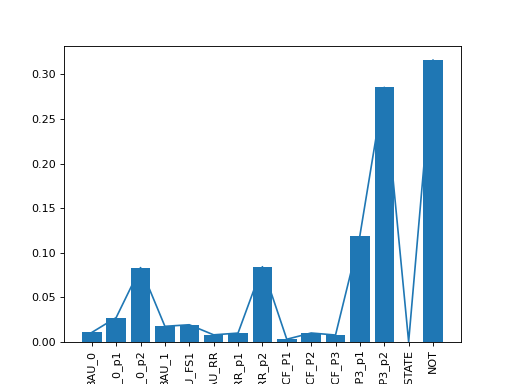

In [87]:
plt.plot([key for key in regimeAmounts.keys()],[val for val in regimeAmounts.values()])

In [88]:
plt.bar(range(len(regimeAmounts)), list(regimeAmounts.values()), align='center')
plt.xticks(range(len(regimeAmounts)), list(regimeAmounts.keys()),rotation="vertical")

([<matplotlib.axis.XTick at 0x7f5c2a6176d0>,
 [Text(0, 0, 'BAU_0'),
  Text(0, 0, 'BAU_0_p1'),
  Text(0, 0, 'BAU_0_p2'),
  Text(0, 0, 'BAU_1'),
  Text(0, 0, 'BAU_FS1'),
  Text(0, 0, 'BAU_RR'),
  Text(0, 0, 'BAU_RR_p1'),
  Text(0, 0, 'BAU_RR_p2'),
  Text(0, 0, 'CCF_P1'),
  Text(0, 0, 'CCF_P2'),
  Text(0, 0, 'CCF_P3'),
  Text(0, 0, 'CCF_P3_p1'),
  Text(0, 0, 'CCF_P3_p2'),
  Text(0, 0, 'CCF_STATE'),
  Text(0, 0, 'NOT')])

## Export data as csv
- Solution_alldata contains the optimal regime per stand AND the timely development of indicator values plus all other input columns (represented_are_by_NFIplot, region, NUTS2)
- Solution contains only the selected optimal regime and its share (if multiple regimes per stand are selected)

In [89]:
try:
    os.mkdir("results")
except FileExistsError:
    pass
b = []
c = []
for key in mfo.regimesDecision.keys():
    if mfo.regimesDecision[key].solution_value() > 0:
        b = b+ [(key[0],x*5+2012, key[1]) for x in range(0,21)]
        c = c+ [(key[0],key[1],mfo.regimesDecision[key].solution_value())]
data2b = mfo.data.iloc[mfo.data.index.isin(b)]
data2b.to_csv("./results/"+scenario+"_"+RCP+"_data.csv")
c1 = pd.DataFrame(c)
c1.to_csv("./results/"+scenario+"_"+RCP+"_solutions.csv")

## Export objective ranges

Save as json file

In [90]:
import json
mfo.objectiveRanges

with open('./results/objectiveRanges_'+scenario+'_'+RCP+'.json', 'w') as json_file:
  json.dump(mfo.objectiveRanges, json_file)

Save as CSV.

In [91]:
import pandas
df = pandas.read_json('./results/objectiveRanges_'+scenario+'_'+RCP+'.json')

df.to_csv('./results/objectiveRanges_'+scenario+'_'+RCP+'.csv')

## Export objective values
The optimal solution for each objective.

In [92]:
import os
with open("./results/objectiveValues_"+scenario+"_"+RCP+".csv","w") as file:
    delim = ""
    for objName in mfo.objectiveTypes.keys():
        file.write(delim+objName)
        delim = ","
    file.write("\n")
    delim = ""
    for objName in mfo.objectiveTypes.keys():
        file.write(delim+str(mfo.objective[objName].solution_value()))
        delim = ","
    file.write("\n")